# Currilulum Learning

This project used the Face Mask Detection dataset from Kaggle.

The data set will be divided into easy and difficult. It will compare models with divided and un-divided data.


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split

DATA_DIR = "/content/drive/MyDrive/Mask-Detection"
print("TF version:", tf.__version__)

TF version: 2.14.0


In [2]:
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available !")

GPU available


# **Preparation of data**

#### Data Conversion

In [3]:
def convert_xml_to_csv(xml_list):
  cols = ["filename", "width", "height","class", "xmin", "ymin", "xmax", "ymax"]
  rows = []
  # Parsing the XML file
  for xml_file in xml_list:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      value = (root.find('filename').text,
      int(root.find('size')[0].text),
      int(root.find('size')[1].text),
      member[0].text,
      int(float(member.find('bndbox').find('xmin').text)),
      int(float(member.find('bndbox').find('ymin').text)),
      int(float(member.find('bndbox').find('xmax').text)),
      int(float(member.find('bndbox').find('ymax').text)))
      rows.append(value)
  df = pd.DataFrame(rows, columns=cols)
  return df

In [4]:
labels = [os.path.join(DATA_DIR, xml_filename)
              for xml_filename in os.listdir(DATA_DIR)
              if xml_filename.endswith("xml")]

labels_csv = convert_xml_to_csv(labels)
labels_csv.to_csv("labels.csv", index=None)
print(labels_csv.head())

              filename  width  height      class  xmin  ymin  xmax  ymax
0  maksssksksss368.png    400     267  with_mask   354    36   375    64
1  maksssksksss368.png    400     267  with_mask   314    23   339    53
2  maksssksksss368.png    400     267  with_mask   253    35   278    61
3  maksssksksss368.png    400     267  with_mask   195    54   212    77
4  maksssksksss368.png    400     267  with_mask   175    57   191    75


#### Check Data

In [5]:
filenames = ["/content/drive/MyDrive/Mask-Detection/" + fname for fname in labels_csv["filename"]]
filenames[:10]

['/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss368.png',
 '/content/drive/MyDrive/Mask-Detection/maksssksksss134.png']

In [6]:
labels = labels_csv["class"].to_numpy()
unique_class = np.unique(labels)
print("Classes", unique_class)

Classes ['mask_weared_incorrect' 'with_mask' 'without_mask']


In [7]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


Text(0.5, 1.0, 'Class Distribution')

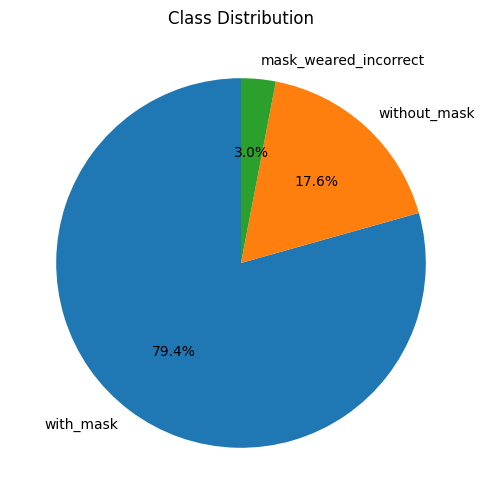

In [8]:
class_counts = labels_csv['class'].value_counts().reset_index()
class_counts.columns = ['class', 'count']
plt.figure(figsize=(8, 6))
plt.pie(class_counts['count'],
        labels=class_counts['class'],
        autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")

#### Split Train and Validation Set

In [9]:
boolean_labels = [label == unique_class for label in labels]
boolean_labels[77:80]

[array([False,  True, False]),
 array([False, False,  True]),
 array([False,  True, False])]

In [10]:
X = filenames
y = boolean_labels

train_images, valid_images, train_labels, valid_labels = train_test_split(filenames,
                                                                          boolean_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)

len(train_images), len(train_labels), len(valid_images), len(valid_labels)

(3257, 3257, 815, 815)

### Turning images into Tensors


In [11]:
image = imread(filenames[84])
image.shape

(225, 400, 4)

In [12]:
IMG_SIZE = 224

def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3) #Normalization
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [13]:
def get_image_and_label(image_path, label):
  """
  Takes an images file path and label, processes the image and
  returns a tuple of image,label
  """
  image = process_image(image_path)
  return image, label

In [14]:
BATCH_SIZE = 32

def create_data_batches(x, y=None, batch_size = BATCH_SIZE, valid_data= False, test_data = False):
  """
  Creates batches of data
  image(X) and label(y)
  Shuffles data  if it is training data
  Accept test data as input with no labels
  """

  if test_data:
    print("Creating test batches..")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating valid batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data_batch = data.map(get_image_and_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating train batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data = data.shuffle(buffer_size = len(x))
    data_batch = data.map(get_image_and_label).batch(BATCH_SIZE)
    return data_batch

In [15]:
train_data = create_data_batches(train_images, train_labels)
valid_data = create_data_batches(valid_images, valid_labels, valid_data=True)

Creating train batches..
Creating valid batches..


In [16]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 3), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 3), dtype=tf.bool, name=None)))

### Visualizing Data Batches

In [17]:
def show_images(images, labels):
  """
  Display a plot of images and their labels from a data batch
  """
  plt.figure(figsize=(10,10))
  image_num = 9                                #@param {type:"slider", min:1, max:50, step:1}
  for i in range(image_num):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(unique_class[labels[i].argmax()])
    plt.axis("off")


In [18]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels) #Batch Size

(32, 32)

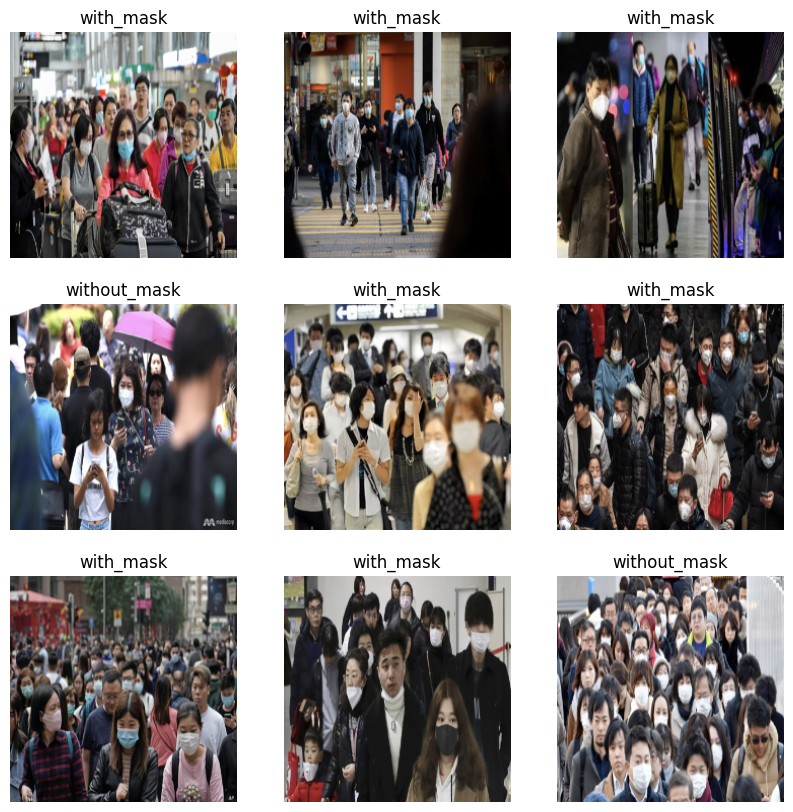

In [19]:
show_images(train_images,train_labels)

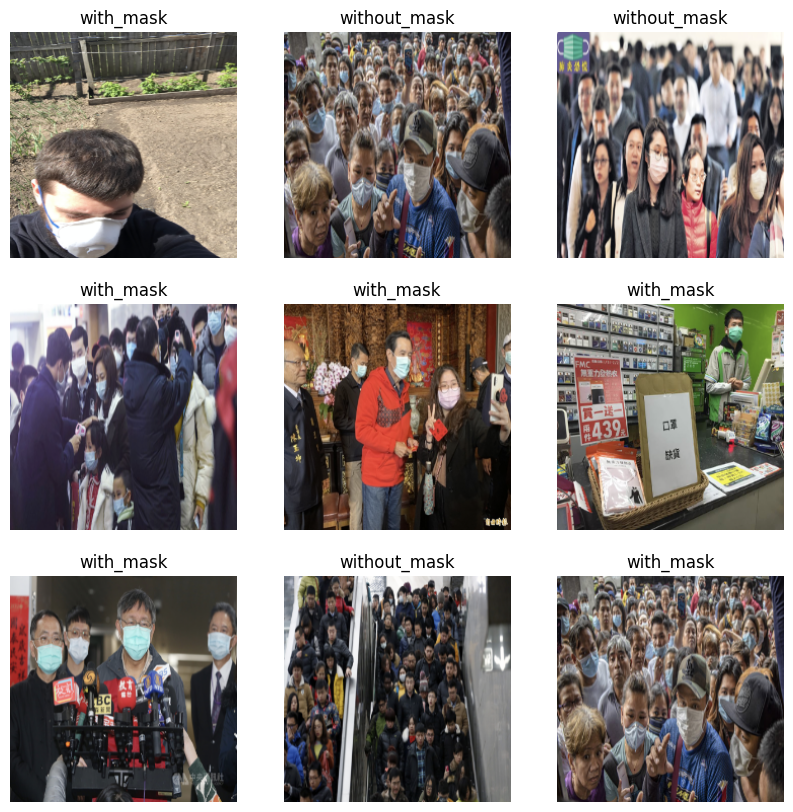

In [20]:
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_images(valid_images, valid_labels)

## Create Model

In [21]:
INPUT_SHAPE = [32, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels
OUTPUT_SHAPE = len(unique_class)

MODEL_URL =  "https://tfhub.dev/google/imagenet/inception_v2/classification/5"

In [22]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with ", MODEL_URL)

  #Create Model Layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), #Layer 1
      tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                            activation = "softmax") # Layer 2
  ])

  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )
  model.build(INPUT_SHAPE)

  return model

In [23]:
model = create_model()
model.summary()

Building model with  https://tfhub.dev/google/imagenet/inception_v2/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (32, 1001)                11199137  
                                                                 
 dense (Dense)               (32, 3)                   3006      
                                                                 
Total params: 11202143 (42.73 MB)
Trainable params: 3006 (11.74 KB)
Non-trainable params: 11199137 (42.72 MB)
_________________________________________________________________


#### Callbasks

In [24]:

import datetime

def create_tensorboard_callback():
  logdir = os.path.join("/content/drive/MyDrive/Mask-Detection/",datetime.datetime.now().strftime("%Y%m%d"))
  return tf.keras.callbacks.TensorBoard(logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7)

## **TRAINING**

In [25]:
NUM_EPOCHS = 5

def train_model():
  """
  Trains a given model and returns the trained version.
  """
  model = create_model()
  tensorboard = create_tensorboard_callback()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

In [26]:
model = train_model()

Building model with  https://tfhub.dev/google/imagenet/inception_v2/classification/5
Epoch 1/5
102/102 [==============================] - 66s 550ms/step - loss: 0.6578 - accuracy: 0.7832 - val_loss: 0.5653 - val_accuracy: 0.8184
Epoch 2/5
102/102 [==============================] - 43s 426ms/step - loss: 0.5096 - accuracy: 0.8152 - val_loss: 0.5428 - val_accuracy: 0.8172
Epoch 3/5
102/102 [==============================] - 47s 462ms/step - loss: 0.4798 - accuracy: 0.8256 - val_loss: 0.5714 - val_accuracy: 0.7877
Epoch 4/5
102/102 [==============================] - 47s 458ms/step - loss: 0.4751 - accuracy: 0.8222 - val_loss: 0.5919 - val_accuracy: 0.8049
Epoch 5/5
102/102 [==============================] - 46s 450ms/step - loss: 0.4446 - accuracy: 0.8367 - val_loss: 0.5184 - val_accuracy: 0.8233


In [28]:
%load_ext tensorboard
%tensorboard --logdir "/content/drive/MyDrive/Mask-Detection",datetime.datetime.now().strftime("%Y%m%d")

predictions = model.predict(valid_data, verbose=1)
predictions


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-10-27 22:06:02.108333: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 22:06:02.108406: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 22:06:02.108436: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 22:06:03.071294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorf

26/26 [==============================] - 11s 414ms/step


array([[0.04224451, 0.34283078, 0.61492467],
       [0.03926125, 0.6813142 , 0.27942458],
       [0.01687548, 0.08787294, 0.8952515 ],
       ...,
       [0.04443732, 0.8225007 , 0.13306196],
       [0.02578206, 0.9480084 , 0.02620954],
       [0.0125872 , 0.94419354, 0.04321926]], dtype=float32)

In [31]:
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[0])}")
print(f"Max index: {np.argmax(predictions[0])}")
print(f"Predicted label: {unique_class[np.argmax(predictions[0])]}")

[0.04224451 0.34283078 0.61492467]
Max value (probability of prediction): 0.6149246692657471
Sum: 1.0
Max index: 2
Predicted label: without_mask


In [33]:
def get_class_name(prediction_probabilities):
  #Returns highest probability class name
  return unique_class[np.argmax(prediction_probabilities)]

prediction_labels = get_class_name(predictions[0])
prediction_labels

'without_mask'

In [37]:
def unbatchify(data):
  """
  Since our validation data is in batch form,
  to get a list of validation images and labels,
  """
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_class[np.argmax(label)])
  return images, labels

valid_images, valid_labels = unbatchify(valid_data)
valid_images[0], valid_labels[0]

(array([[[0.27456015, 0.30237   , 0.28348652],
         [0.29522935, 0.3132966 , 0.30735296],
         [0.28077295, 0.30016413, 0.29364496],
         ...,
         [0.21096815, 0.21606489, 0.21356137],
         [0.20877758, 0.21476716, 0.2062697 ],
         [0.20670737, 0.21541274, 0.20898548]],
 
        [[0.26510638, 0.28670782, 0.28149292],
         [0.27347034, 0.2908176 , 0.29151785],
         [0.26827297, 0.2844122 , 0.2857143 ],
         ...,
         [0.29202995, 0.2923757 , 0.2714986 ],
         [0.3169052 , 0.3163056 , 0.2987986 ],
         [0.31271884, 0.31399903, 0.29382443]],
 
        [[0.26666668, 0.28873205, 0.28627452],
         [0.26868874, 0.284375  , 0.28829658],
         [0.27383798, 0.28952426, 0.2935662 ],
         ...,
         [0.25675553, 0.25744706, 0.24192053],
         [0.27652094, 0.27868304, 0.26327688],
         [0.2925617 , 0.29281774, 0.27741158]],
 
        ...,
 
        [[0.1927521 , 0.19927128, 0.22036718],
         [0.15402447, 0.15611435, 0.18168

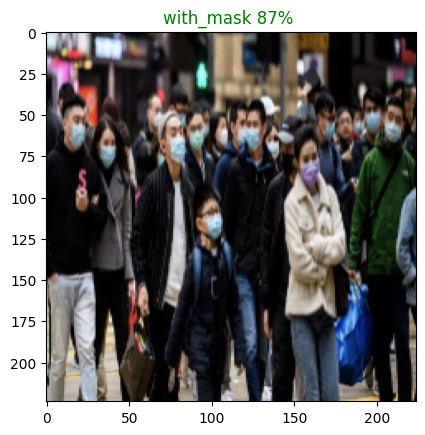

In [38]:
def plot_pred(prediction_probabilities, labels, images, n=52):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  prediction_label = get_class_name(pred_prob)

  plt.imshow(image)

  if prediction_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ".format(prediction_label,
                                  np.max(pred_prob)*100),
                                  color=color)

plot_pred(prediction_probabilities=predictions,
          labels=valid_labels,
          images=valid_images)

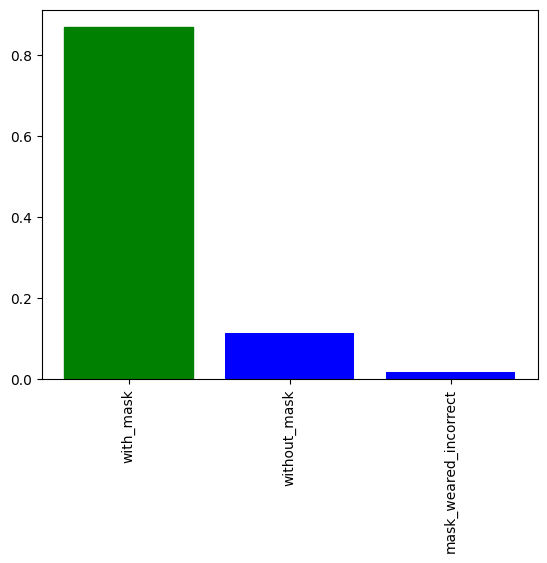

In [42]:
def plot_prediction_conf(prediction_probabilities, labels, n=52):

  pred_prob, true_label = prediction_probabilities[n], labels[n]
  pred_label = get_class_name(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-5:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_prediction_labels = unique_class[top_10_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_10_prediction_labels)),
                     top_10_pred_values,
                     color="blue")
  plt.xticks(np.arange(len(top_10_prediction_labels)),
             labels=top_10_prediction_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_prediction_labels):
    top_plot[np.argmax(top_10_prediction_labels == true_label)].set_color("green")
  else:
    pass

plot_prediction_conf(prediction_probabilities=predictions,
               labels=valid_labels,
               n=52)

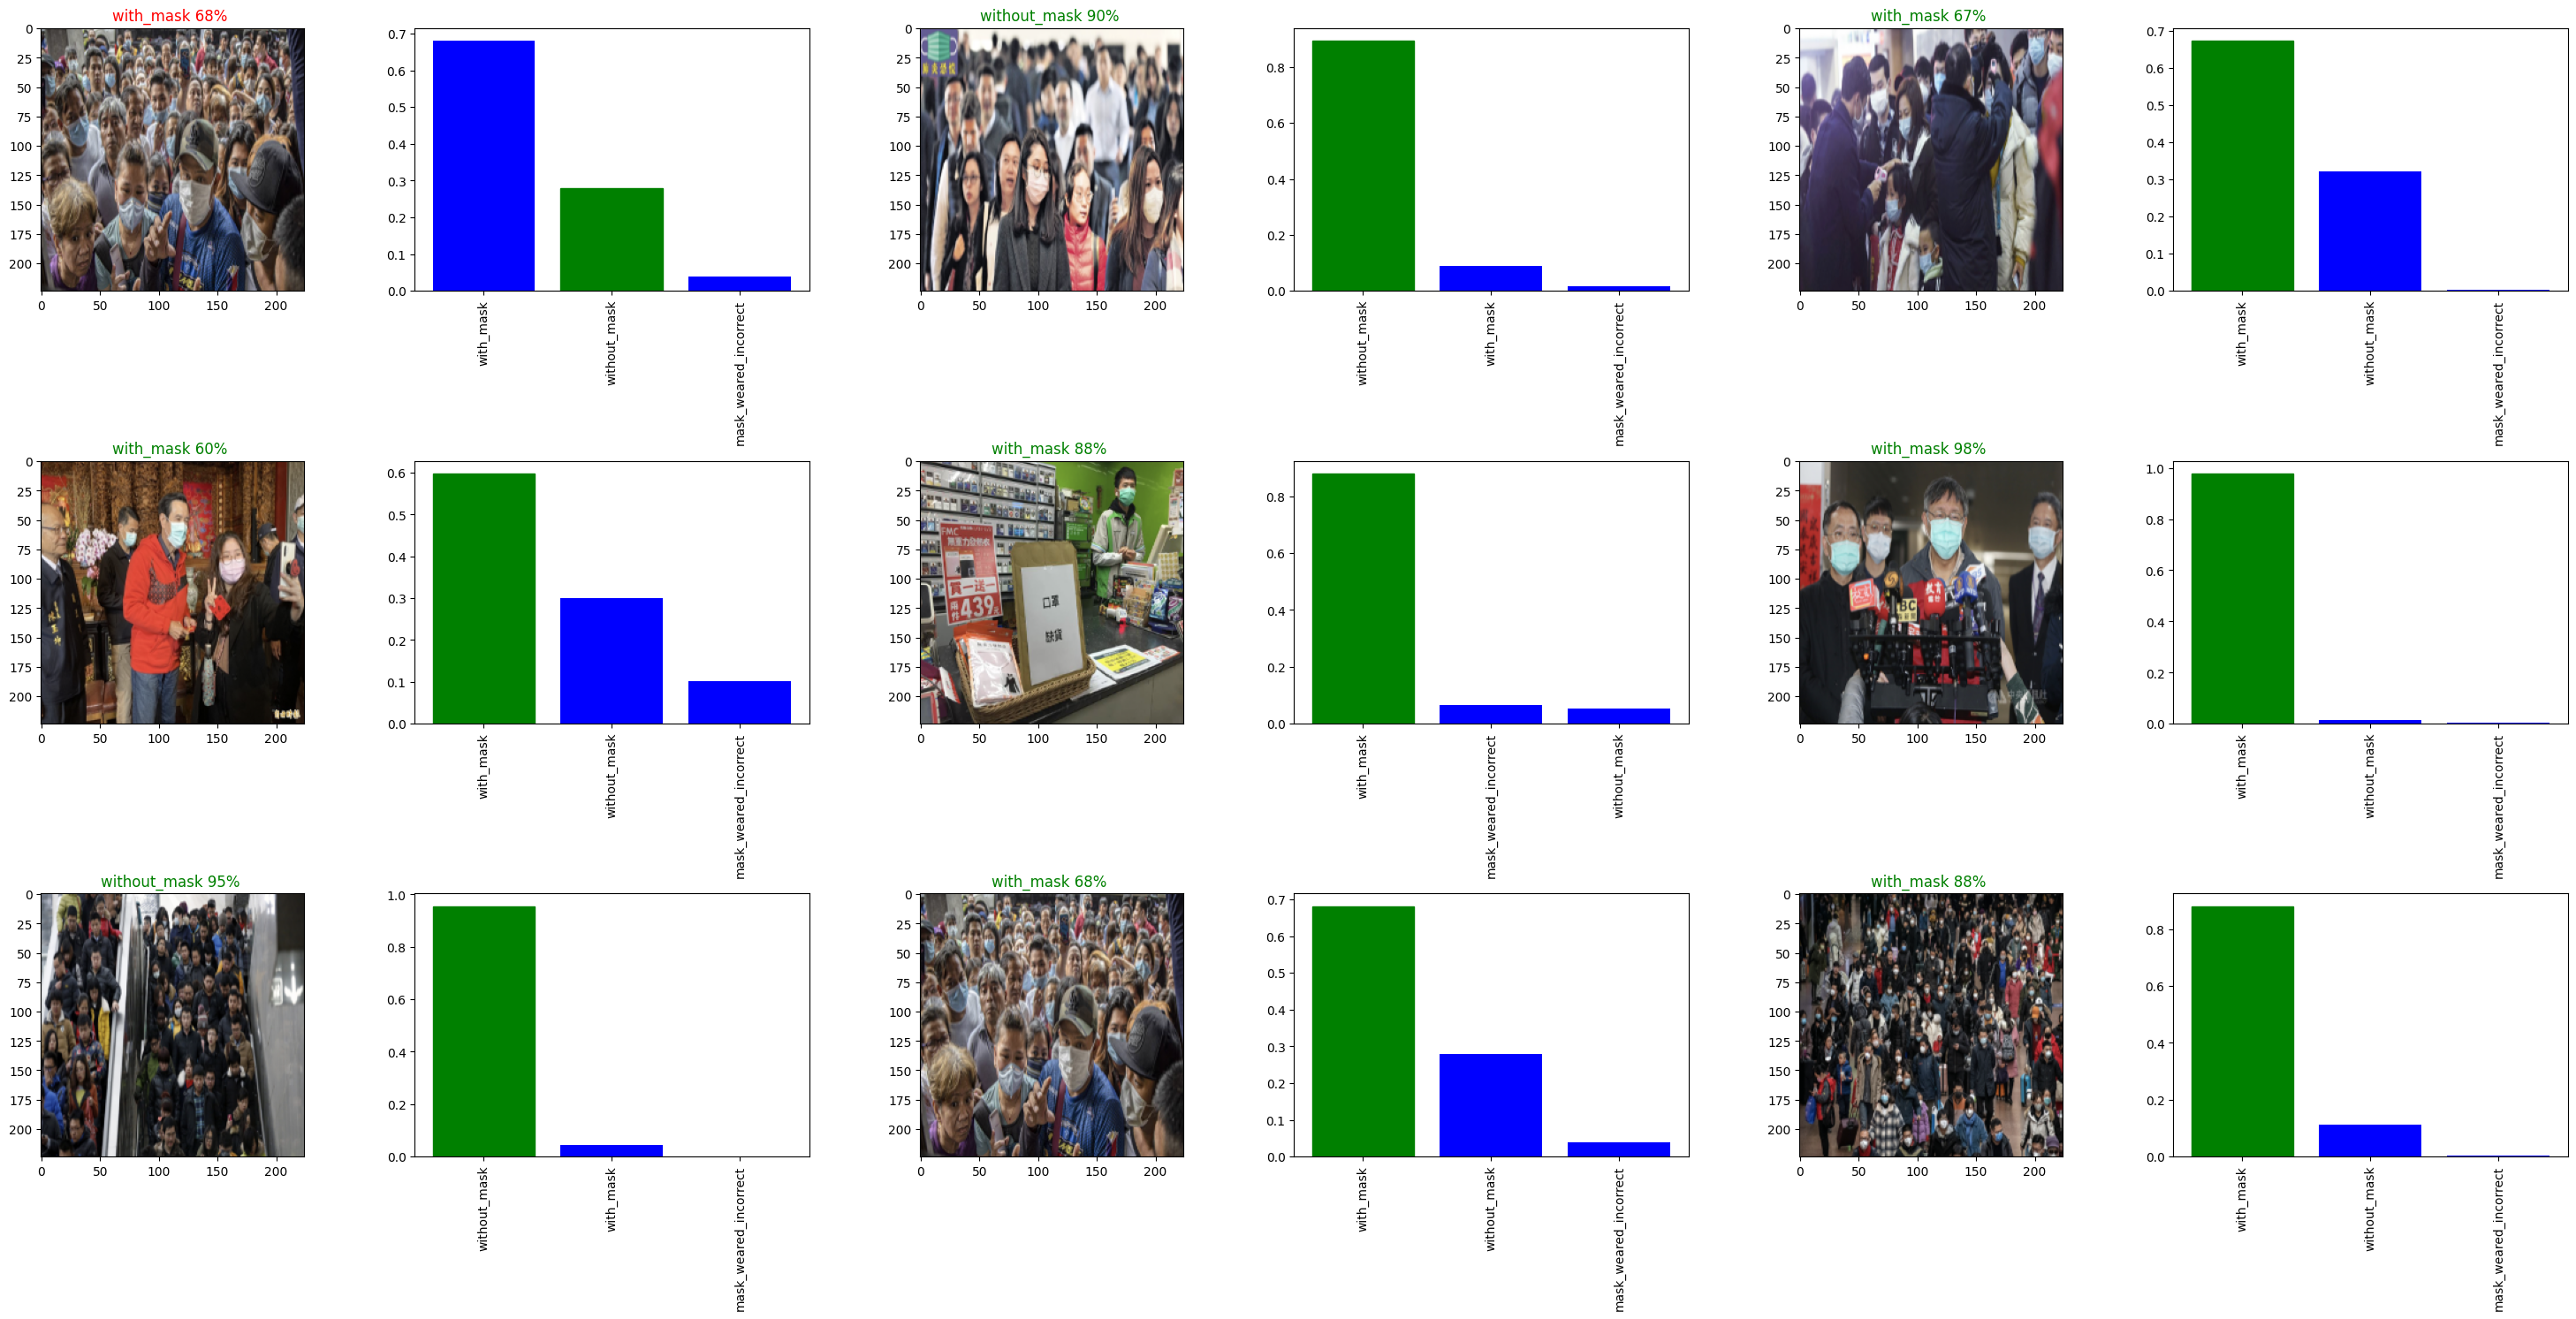

In [43]:
selective = 1
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=valid_labels,
            images=valid_images,
            n=i+selective)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_prediction_conf(prediction_probabilities=predictions,
                labels=valid_labels,
                n=i+selective)
plt.tight_layout(h_pad=1.0)
plt.show()